In [1]:
import numpy as np
import csv
from matplotlib import cm
import matplotlib.pyplot as plt
import copy

# Fig 3c

### load data

In [2]:
sfacs = [1, 1.2, 1.6]; nsfacs = len(sfacs)
nbootstrap = 100
fit_orders = [1, 'exp']; nfits = len(fit_orders)

# load bootstrap, unmitigated data
data_bootstrap_unmit = {}
with open("data/fig3c_bootstrap_unmit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nsfacs, nbootstrap))
        data_bootstrap_unmit[float(d[0])] = data
        
# load bootstrap, mitigated data
data_bootstrap_mit = {}
with open("data/fig3c_bootstrap_mit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nbootstrap, nfits, 2)) # the last 2 is value/fit uncertainty
        data_bootstrap_mit[float(d[0])] = data
        
# load experimental, unmitigated data
data_exp_unmit = {}
with open("data/fig3c_experiment_unmit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nsfacs))
        data_exp_unmit[float(d[0])] = data
        
# load experimental, unmitigated data
data_exp_mit = {}
with open("data/fig3c_experiment_mit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nfits, 2)) # the last 2 is value/fit uncertainty
        data_exp_mit[float(d[0])] = data
        
# load corresponding pauli string (1th qubit --- 127th qubit order)
paulis = []
with open("data/fig3c_pauli.txt", 'r') as f:
    for d in csv.reader(f):
        paulis.append(d)
# it is only one line of data so take 0th in the list
pauli = [p.replace(' ', '') for p in paulis[0]][0] # make sure to remove whitespace padding

In [3]:
percentile_=68.2
criteria=0.5
ysign=-1
percentile=50 + percentile_/2.0 #percentile_ + (100-percentile_)/2.0

In [4]:
import copy

idx_sfac1 = sfacs.index(1)

x_angles=[]
y_unmit=[]
y_unmit_err=[[], []]
y_mit=[]
y_mit_err=[[], []]

y_unmit_exp=[]
y_mit_exp=[]

for angle, unmit in data_bootstrap_unmit.items():
    mit = data_bootstrap_mit[angle]
    mit_exp = data_exp_mit[angle]
    y_unmit_exp.append(data_exp_unmit[angle][idx_sfac1])
    x_angles.append(angle)
    
    # unmitigated value for bootstrap
    unmit_c1 = unmit[idx_sfac1,:]
    a = np.median(unmit_c1)
    b = np.percentile(unmit_c1, 100-percentile)
    c = np.percentile(unmit_c1, percentile)
    y_unmit.append(a)
    if ysign == -1:
        y_unmit_err[1].append( (a-b) )
        y_unmit_err[0].append( (c-a) )
    else:
        y_unmit_err[0].append( (a-b) )
        y_unmit_err[1].append( (c-a) )
    
    # mitigated value for bootstrap
    mit_best=copy.copy(unmit[idx_sfac1,:])

    for n in range(nbootstrap):
        for k in range(nfits):
            tmp = np.where(mit[:,k,1] < criteria)[0]
            mit_best[tmp] = mit[tmp,k,0]
    a = np.median(mit_best)
    b = np.percentile(mit_best, 100-percentile)
    c = np.percentile(mit_best, percentile)
    y_mit.append(a)
    if ysign == -1:
        y_mit_err[1].append( (a-b) )
        y_mit_err[0].append( (c-a) )
    else:
        y_mit_err[0].append( (a-b) )
        y_mit_err[1].append( (c-a) )

    # mitigated value for experiment
    y_mit_exp_ = copy.copy(data_exp_unmit[angle][idx_sfac1])
    for k in range(nfits):
        if mit_exp[k, 1] < criteria:
            y_mit_exp_ = mit_exp[k, 0]
    y_mit_exp.append(y_mit_exp_)

In [5]:
# sort by x axis
idx = np.argsort(x_angles)
x_angles = np.array(x_angles)[idx]
y_unmit=np.array(y_unmit)[idx]
y_unmit_err=[np.array(vals)[idx] for vals in y_unmit_err]
y_mit=np.array(y_mit)[idx]
y_mit_err=[np.array(vals)[idx] for vals in y_mit_err]

y_unmit_exp=np.array(y_unmit_exp)[idx]
y_mit_exp=np.array(y_mit_exp)[idx]

### load simulation data

In [6]:
x, y = [], []
with open("data/fig3c_exact.txt", 'r') as f:
    for d in csv.reader(f):
        x.append(float(d[0]))
        y.append(float(d[1]))
exact_sim = [x, y]

x, y = [], []
with open("data/fig3c_MPS.txt", 'r') as f:
    for d in csv.reader(f):
        x.append(float(d[0]))
        y.append(float(d[1]))
MPS_sim = [x, y]

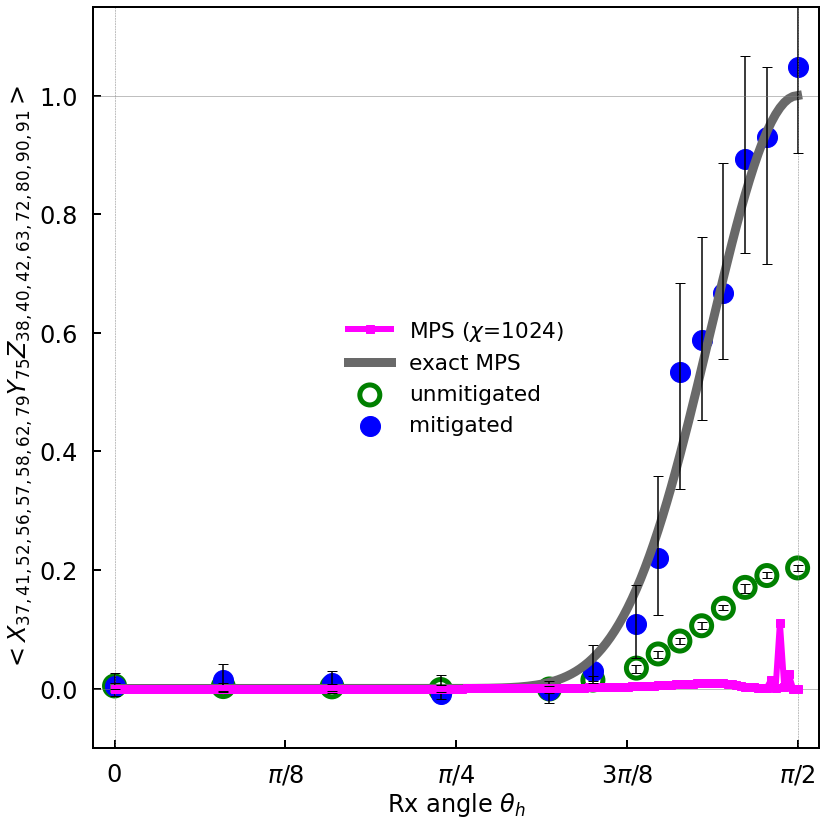

In [7]:
fontsize_global=24
plt.rcParams['font.size'] = fontsize_global
plt.rcParams['axes.linewidth'] = 2

ylim = [-0.1, 1.15]
xfactor = 1
alpha=1.0
markersize_factor=4.0
markersize=2*markersize_factor
markersize_sim=100*markersize_factor
markersize_ideal=1000*markersize_factor
linewidth=6

# pauli_string = [p+'_{'+str(i)+'}' for i, p in enumerate(pauli) if p.upper() != 'I']
# ylabel = '$<'+''.join(pauli_string)+'>$'
pauli_string=[[], [], []]
pauli_string[0]=[str(i) for i, p in enumerate(pauli) if p.upper() == 'X']
pauli_string[1]=[str(i) for i, p in enumerate(pauli) if p.upper() == 'Y']
pauli_string[2]=[str(i) for i, p in enumerate(pauli) if p.upper() == 'Z']
pauli_string_=''
for idxs, p in zip(pauli_string, ['X', 'Y', 'Z']):
    if len(idxs) > 0:
        pauli_string_+=p
        pauli_string_+='_{'
        pauli_string_+=','.join(idxs)
        pauli_string_+='}'
ylabel = '$<'+pauli_string_+'>$'

fit_colors=list(cm.Reds(np.linspace(0.3, 0.9, 3))) + ['b'] + ['g']

ncol=1; nrow=1;
fig, axes = plt.subplots(nrow,ncol, figsize=(12*ncol,12*nrow))

kwargs_c1_exp={'color': 'g', 'label': 'unmitigated', 's': markersize_sim, 'facecolors': 'none', 'linewidths': 5.0}
kwargs_exp={'color': 'b', 'label': 'mitigated', 's': markersize_sim}

ax = axes

ax.axvline(np.pi/2, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(1, color='grey', linestyle='-', linewidth=0.5)
ax.axhline(0, color='grey', linestyle='-', linewidth=0.5)

# MPO simulation results
x, y = MPS_sim
idx = np.argsort(x)
marker='s'; color='magenta'
linewidth_=linewidth
label='MPS ($\chi$=1024)'
#ax.plot(np.array(x)[idx], np.array(y)[idx]*ysign, color=color, label=label)
ax.plot(np.array(x)[idx], np.array(y)[idx]*ysign, color=color, label=label, marker=marker, markersize=markersize, linewidth=linewidth_)

# exact simulation results from lightcone reduced MPS
x, y = exact_sim
idx = np.argsort(x)
marker='.'; color='dimgrey'
linewidth_=linewidth+3; 
label='exact MPS'
ax.plot(np.array(x)[idx], np.array(y)[idx]*ysign, color=color, marker=marker, label=label, linewidth=linewidth_, zorder=1)

ax.errorbar(x_angles, y_unmit*ysign, yerr=y_unmit_err, c='k', fmt='', linestyle='', ecolor='black', barsabove=True, solid_capstyle='projecting', capsize=5)
ax.scatter(x_angles, y_unmit_exp*ysign, **kwargs_c1_exp)

# mitigated
ax.errorbar(x_angles, y_mit*ysign, yerr=y_mit_err, c='k', fmt='', linestyle='', ecolor='black', barsabove=True, solid_capstyle='projecting', capsize=5)
ax.scatter(x_angles, y_mit_exp*ysign, **kwargs_exp)
                
ax.set_xlim(np.array([np.min(x_angles)-0.05, np.max(x_angles) + 0.05])*xfactor)
ax.set_ylim(ylim)  

#ax.legend(frameon=False, loc=(0.6, 0.1), fontsize=fontsize_global*0.9)
ax.legend(frameon=False, fontsize=fontsize_global*0.9)
xticks = np.array([0, 0.125, 0.25, 0.375, 0.5])*np.pi
xticks_label = ['0', '$\pi$/8', '$\pi$/4', '$3\pi$/8', '$\pi$/2']
ax.tick_params(axis="both", direction="in", length=8, width=2, pad=15)
#ax.set_xticks(xticks, xticks_label)
ax.set_xticks(xticks);ax.set_xticklabels(xticks_label)
ax.set_xlabel('Rx angle $\\theta_h$')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     labelleft=False) # labels along the bottom edge are off
ax.set_ylabel(ylabel, fontsize=fontsize_global)

plt.tight_layout()
plt.show()
plt.close()